In [ ]:
import numba
import numpy as np
import random as rd 
import matplotlib.pyplot as plt
import time
from numba import jit, config, threading_layer, set_num_threads
from numpy.random import random as npr
from numpy.random import default_rng
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



# seeds
rd.seed(42)
np.random.seed(42)
rng = default_rng(seed=42)

L = 5 # L = tamanho da rede
L2 = L**2
S = np.array(rd.choices([-1,1], k=L2), dtype=np.float32) # rede  para t=0

# Teq = tempo de equilibrio
Teq = 10**4
# T = tempo de simulação
T = 10**6 - Teq

pm = 50 # tempo entre medidas

viz = np.zeros((L2,4),dtype=np.int64)
c = np.zeros((2,int(L2/2)), dtype=np.int64)




      


In [ ]:
exata5 = pd.read_csv('/content/sumZL5.dat', sep = ' ',  usecols=[0,1,2,3,4], names=['T', 'm', 'e', 'x', 'cv'], header=None)
df = exata5.drop(0).astype(np.float64)


In [ ]:
def init_viz(L2):
    viz = np.zeros((L2,4),dtype=np.int64)
    for sitio in range(L2):
        n1 = ((sitio//L -1 +L2)%L)*L + sitio%L
        n2 = ((sitio//L)%L)*L+(sitio+1+L)%L
        n3 = ((sitio//L +1 +L2)%L)*L +sitio%L
        n4 = ((sitio//L)%L)*L+(sitio-1+L)%L
    
        viz[sitio][0] = n1
        viz[sitio][1] = n2
        viz[sitio][2] = n3
        viz[sitio][3] = n4
    return viz

def init_medidas(s, viz):
    E = 0 
    mag = np.sum(s)                         
    viz = init_viz(L2)                      
    for i in range(L2):
      for j in range(4):
        E = E + s[i]*(s[viz[i][j]])
    E = E*(-1/2)
    
    return E, mag
    
    

# funcao responsavel pelos MCS
@jit(nopython=True)
def passo(s, mag, E, viz, TEMP):
    for i in range(L2):
             sitio = np.random.randint(L2) # vou escolher um sitio aleatorio
             deltae = 2*s[sitio]*(s[viz[sitio,0]] + s[viz[sitio,1]] +s[viz[sitio,2]]+s[viz[sitio,3]])
             prob = np.exp(-deltae/TEMP)
             rfloat1 = npr(1)[0]  # num aleatorio [0,1) | npr() = numpy.random.random()
             if rfloat1 < prob: # if para flipar o sitio
                 s[sitio] = s[sitio]*(-1)
                 mag = mag + 2*s[sitio] # ajustamos a mag
                 E = E + deltae
             
    return mag, E
            
    
def dinamica(s, TEMP):
  viz = init_viz(L2)            # iniciando vizinhos
  E, mag = init_medidas(s, viz) # iniciando energia e mag

  Elist = []
  maglist =[]
  for t in range(Teq):              # loop para equilibrar
      mag, E = passo(s, mag, E, viz, TEMP)

  for t in range(T):                # loop com medidas
      mag, E = passo(s, mag, E, viz, TEMP)

      Elist.append(E)
      maglist.append(mag)


  return  np.array(maglist), np.array(Elist)
    





  

In [ ]:
# Teq = tempo de equilibrio
Teq = 10**4
# T = tempo de simulação
T = 10**5 - Teq

historias = 1
temps = np.linspace(0.5, 5 , 25)



In [ ]:
tmag = []
TE = []
Tcv = []
Tx = []


for temp in temps:
  maglist = []
  Elist = []
  cvlist = []
  xlist = []

  for h in range(historias):
    Sr = np.array(rd.choices([-1,1], k=L2), dtype=np.float32)

    mag, E = dinamica(Sr, temp)
    
    Eeq = np.mean((E/L2))
    Eeq2 = np.mean((E/L2)**2)

    mageq =  np.mean((abs(mag)/L2))
    mageq2 = np.mean(((mag/L2)**2))
    
    xlist.append(L2/temp*(mageq2 - (mageq**2)))
    cvlist.append(L2/(temp**2)*(Eeq2 - (Eeq**2)))


    Elist.append(Eeq)
    maglist.append(mageq)


  Tx.append(np.mean(xlist)) 
  Tcv.append(np.mean(cvlist))   
  TE.append(np.mean(Elist))  
  tmag.append(np.mean(maglist)) 

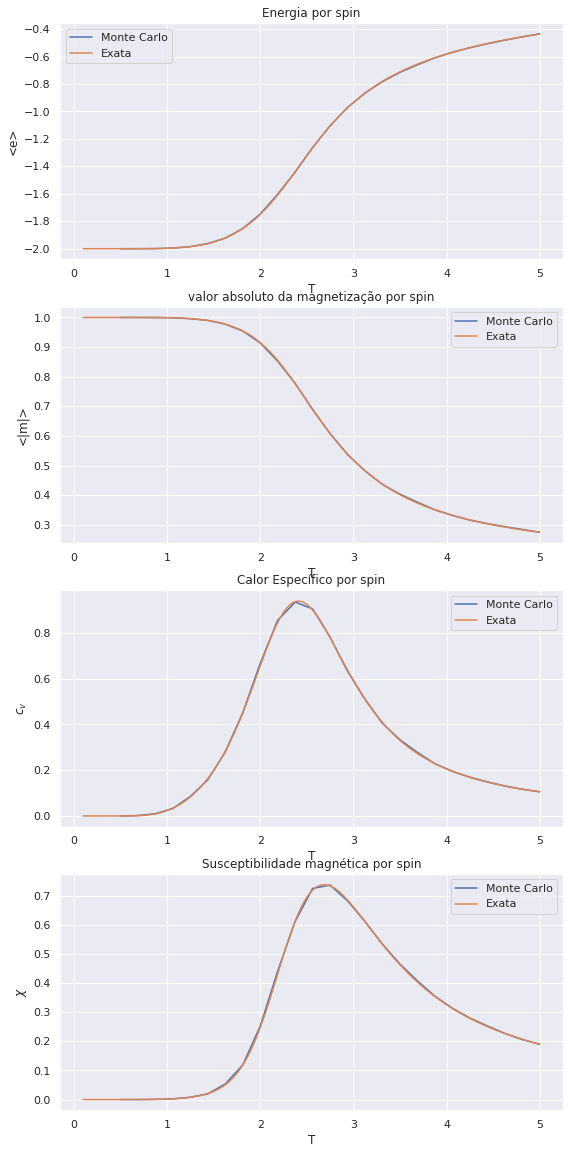

In [ ]:
#L = 5
sns.set()
fig, ax = plt.subplots(4,1, figsize=(9,20))


ax[0].plot(temps, TE, label='Monte Carlo')
ax[0].plot(df['T'],df['e'] , label='Exata')
ax[0].set(xlabel='T', ylabel='<e>', title='Energia por spin' )
ax[0].legend()

ax[1].plot(temps, tmag, label='Monte Carlo')
ax[1].plot(df['T'],df['m'],  label='Exata')
ax[1].set(xlabel='T', ylabel='<|m|>', title='valor absoluto da magnetização por spin' )
ax[1].legend()

ax[2].plot(temps, Tcv, label='Monte Carlo')
ax[2].plot(df['T'],df['cv'],  label='Exata')
ax[2].set(xlabel='T', ylabel='$c_v$', title='Calor Específico por spin' )
ax[2].legend()

ax[3].plot(temps, Tx, label='Monte Carlo')
ax[3].plot(df['T'],df['x'], label='Exata')
ax[3].set(xlabel='T', ylabel='$\chi$', title='Susceptibilidade magnética por spin' )
ax[3].legend()


plt.savefig("Tarefa8.pdf")